In [ ]:

#%%
import torch

args = {
    'epoch_num': 100,     # Number of epochs.
    'lr': 1.0e-3,           # Learning rate.
    'weight_decay': 10e-4, # L2 penalty.
    'momentum': 0.9,      # Momentum.
    'batch_size': 2,     # Mini-batch size. 600
    'batch_test': 2,     # size of test batch
}

if torch.cuda.is_available():
    args['device'] = torch.device('cuda')
else:
    args['device'] = torch.device('cpu')

print(args['device'])

dataset_name = "PAMAP2"

#"OurConvLSTM", "AttentionTransformer", "DeepConvLSTM", "CnnIMU"

from collections import defaultdict

adict = defaultdict(dict)

all_subs = list(range(8))
val_sub = 3
for plot_subject in [i for i in all_subs if i != val_sub]:


  ! pip install wget
  import os
  import torch
  import pandas as pd
  import numpy as np
  import torch
  from torch import nn


  ssh_config = """
  Host github.com
    IdentityFile ~/.ssh/github.pem
    User davipeag
    StrictHostKeyChecking no
  """

  if os.name == 'nt':
    base_path = ""
    REPO_DIR = "."
    STORE_DIR ="." 
    print("Windows")
  else:
    print("Unix-like")
    REPO_DIR = "/tmp/HeartRateRegression"
    from google.colab import drive
    drive.mount('/content/drive')
    GIT_PATH = "/content/drive/My\ Drive/deeplearning_project/github.pem"
    DATA_PATH = "/content/drive/My\ Drive/deeplearning_project/normalized.zip"
    STORE_DIR ="/content/drive/My Drive/deeplearning_project/" 
    !mkdir ~/.ssh
    !cp -u {GIT_PATH} ~/.ssh/
    !chmod u=rw,g=,o= ~/.ssh/github.pem
    !echo "{ssh_config}" > ~/.ssh/config
    !chmod u=rw,g=,o= ~/.ssh/config
    ! (cd /tmp && git clone git@github.com:davipeag/HeartRateRegression.git)
    ! (cd {REPO_DIR} && git pull )
    import sys
    sys.path.append(REPO_DIR)



  def git_push():
    if os.name == 'nt':
      pass
    else:
      ! git config --global user.email "daviaguiar@outlook.com"
      ! git config --global user.name "Davi Pedrosa de Aguiar"
      print("going to push")
      ! (cd {REPO_DIR} && git pull && cd -)
      ! (cd {REPO_DIR} && git add . && git commit -m "from colab" && git push)

  def git_pull():
    if os.name == 'nt':
      pass
    else:
      ! git config --global user.email "daviaguiar@outlook.com"
      ! git config --global user.name "Davi Pedrosa de Aguiar"
      print("going to push")
      ! (cd {REPO_DIR} && git pull && cd -)
      
    
  git_push()



  from data_utils import (
      Pamap2Handler, cross_validation_split)

  from default_utils import DefaultPamapPreprocessing
  from preprocessing_utils import (OurConvLstmToAttentionFormat, OurConvLstmToCnnImuFormat)

  from models_utils import OurConvLstmDataset, make_loader, reset_seeds
  from models_utils import DatasetXY

  from default_utils import TrainOurConvLSTM, TrainXY
  from default_utils import make_our_conv_lstm, make_attention_transormer_model 
  from torch import nn

  from options import (
    preprocessing_options,
    trainer_options,
    dataset_cls_options,
    net_options
  )

  reset_seeds()


  #%%

#   dataset_handler = Pamap2Handler(os.path.join(REPO_DIR, ".."))

#   dfs = [dataset_handler.get_protocol_subject(s) for s in [1,2,3,4,5,6,7,8]]
#   df_full = pd.concat(dfs)

  dataset_handler = Pamap2Handler(os.path.join(REPO_DIR, ".."))

  df_ts = dataset_handler.get_protocol_subject(plot_subject + 1)

  max_size = (len(df_ts)//300) -  10

  total_size = 162# max_size
  is_size = 2 
  recursive_size = total_size - is_size
  #total_size = recursive_size + is_size
  
  #models = ["DeepConvLSTM", "FCNN", "CnnIMU", "OurConvLSTM"]
  models = ["FCNN", "AttentionTransformer", "DeepConvLSTM", "CnnIMU", "OurConvLSTM"]

  from default_utils import FcPamapPreprocessing, make_fcnn

  preprocessors =[preprocessing_options[model](total_size) for model in models]
  tdata = list()
  for preprocessor in preprocessors:
      tdata.append(preprocessor.transformers_ts.transform(df_ts))

  datasets_cls = [dataset_cls_options[model_type] for model_type in models]

  loaders = [make_loader([xy], dataset_cls, batch_size = args["batch_size"], shuffle=False)
              for dataset_cls, xy in zip(datasets_cls, tdata)]


  from default_utils import make_cnn_imu2
  from default_utils import make_deep_conv_lstm


  nets = [net_options[model_type](total_size, recursive_size, args["device"]).to(args["device"]) for model_type in models]

  criterion = nn.L1Loss().to(args["device"]) 

  trainers = list()

  for preprocessor,net, model_type in zip(preprocessors,nets, models):

      optimizer = torch.optim.Adam(net.parameters(), lr=args["lr"],
                              weight_decay=args["weight_decay"])

      basic_training_parameters = {
          "net": net,
          "criterion": criterion,
          "optimizer": optimizer,
          "loader_tr": None,
          "loader_val": None,
          "loader_ts": None,
          "normdz": preprocessor.normdz,
          "ztransformer": preprocessor.ztransformer,
          "device": args["device"]
      }


      trainer = trainer_options[model_type](basic_training_parameters)
      trainers.append(trainer)

  import os
  import matplotlib.pyplot as plt
  from collections import OrderedDict
  import copy 

  figures = list()
  for idx in range(1):
    sdict = OrderedDict()
    fig, ax = plt.subplots(figsize=(15,10))
    figures.append((fig, ax))
    for model_type, loader, trainer in list(zip(models, loaders, trainers))[0:]:
        mae = trainer.compute_mean_MAE(loader)
        
        state_dict_name = f"trained_models/{model_type}ts_{plot_subject}_val_{val_sub}.pkl"
        state_dict_path = os.path.join(STORE_DIR, state_dict_name)
        trainer.net.load_state_dict(torch.load(state_dict_path, map_location=args["device"]))
        y,p = trainer.reverse_transformed_prediction_labels(loader)
        mae = np.abs(y-p).mean()
        max_deviation = np.abs(y-p).max()
        print(f"{model_type}_ts_{plot_subject}_val_{val_sub}: mae: {mae}, max_deviation: {max_deviation}")
        sdict[f"{model_type}"] = p
        sdict[f"{model_type}_label"] = y
        ax.plot(np.linspace(0, 3*(len(p[idx])-1), len(p[idx])), p[idx], label=model_type)
    adict[f"subject_{plot_subject}"] = copy.deepcopy(sdict)
    ax.plot(np.linspace(0, 3*(len(p[idx])-1), len(p[idx])), y[idx], 'k', label="actual")
    ax.set_ylabel("heart rate [beats per minute]")
    ax.set_xlabel("time[seconds]")
    ax.legend()
    fig.show()


cpu
Unix-like
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mkdir: cannot create directory ‘/root/.ssh’: File exists
fatal: destination path 'HeartRateRegression' already exists and is not an empty directory.
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 3 (delta 2), reused 3 (delta 2), pack-reused 0
Unpacking objects: 100% (3/3), done.
From github.com:davipeag/HeartRateRegression
   b84f1da..48eb12e  master     -> origin/master
Updating b84f1da..48eb12e
Fast-forward
 options.py | 2 +-
 1 file changed, 1 insertion(+), 1 deletion(-)
going to push
Already up to date.
/content
On branch master
Your branch is up to date with 'origin/master'.

nothing to commit, working tree clean
FCNN_ts_0_val_3: mae: 12.617111206054688, max_deviation: 47.48078918457031
AttentionTransformer_ts_0_val_3: mae: 14.22553539276123, max

In [6]:
import pickle

with open(os.path.join(STORE_DIR, "baseline_models_160.pkl"), "wb") as f:
  pickle.dump(adict, f)
  


In [2]:
# df = pd.DataFrame.from_dict(adict)

# adict.keys()
mae = np.abs(y-p).mean()
max_deviation = np.abs(y-p).max()

mae, max_deviation
# ax = df[["label_1", "CnnIMU_1", "OurConvLSTM_1"]].plot()
# ax.set_xlabel("elapsed time [s]")
# ax.set_ylabel("heart rate [bps]")

(38.690804, 118.92746)

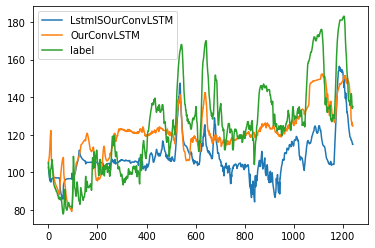

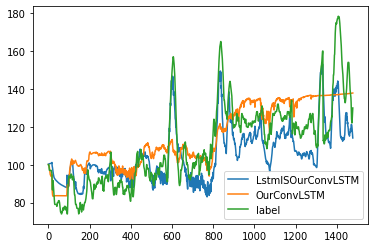

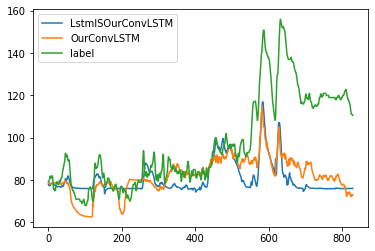

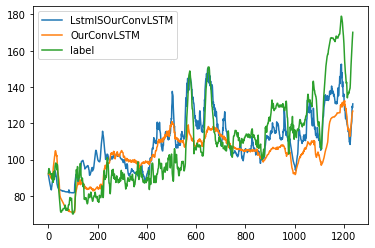

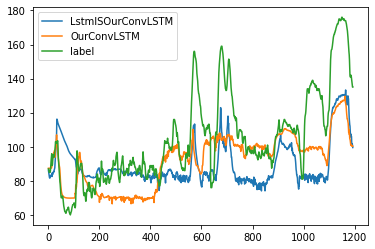

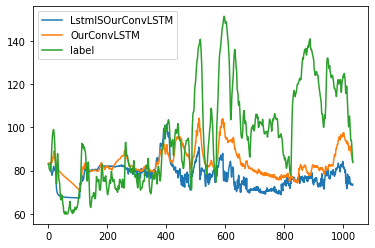

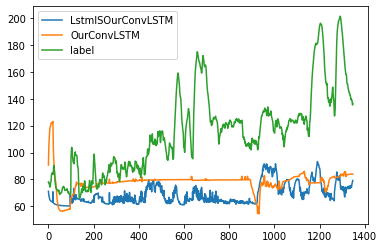

In [32]:
for i in [0,1,2,4,5,6,7]:
  
  df  = adict[f"subject_{i}"]

  df[["LstmISOurConvLSTM","OurConvLSTM", "label"]].plot()

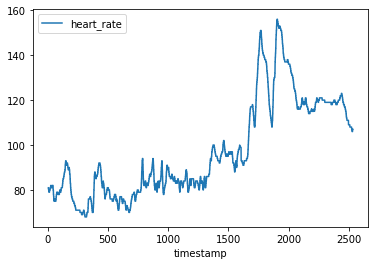

In [14]:
df = dataset_handler.get_protocol_subject(3)
df1 = df.set_index("timestamp")
df1[["heart_rate"]].dropna().plot()

In [4]:
(df["label_0"] - df["CnnIMU_0"]).abs().mean(), (df["label_0"] - df["OurConvLSTM_0"]).abs().mean() 

NameError: ignored

In [ ]:
x,l = loaders[1].__iter__().__next__()
net= trainers[1].net
v = net(x)
v.shape

# loader = loaders[-1]
# models

In [ ]:
x.shape
cval = net.conv(x)

In [ ]:
lo, _ = net.lstm(torch.flatten(cval.transpose(2,1),start_dim=2))
lo.shape

In [ ]:
net.mask

In [ ]:
xi, yi, xr, yp, p = trainer.get_data_epoch(loader_ts)

print(trainer.HR_MAE(yi, yp, p))
# yr = trainer.inverse_transform_label(yi,yp)
# pr = trainer.inverse_transform_label(yi,p)

yi = yi.detach().cpu().numpy()
yp = yp.detach().cpu().numpy()
p = p.detach().cpu().numpy()

yr = trainer.inverse_transform_label(yi,yp)
pr = trainer.inverse_transform_label(yi,p)

np.mean(np.abs(pr-yr))
#trainer.HR_MAE(yi, yr, p)
#pr.shape, yr.shape

In [ ]:
plt.plot(yr[0])
plt.plot(pr[0])
np.mean(np.abs(pr[0]-yr[0]))

In [ ]:
batch = loader_ts.__iter__().__next__()

In [ ]:
df_ts.__len__()/300